In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pulsefig
from pulsefig.element import Element
from pulsefig.line import Line, LineEnsemble
import numpy as np

LineEnsemble with 2 lines :
	Line : e_f
	Line : g_h

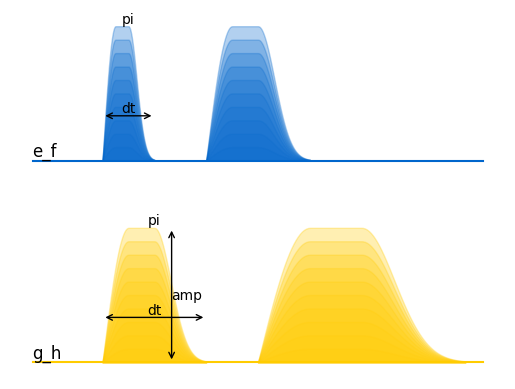

In [6]:
fig, ax = plt.subplots(1, 1)
ax.axis("off")

line1 = Line("e_f").attach_elements(
    Element(0, 1)
    .set(alpha=0.3, marker="0")
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1)
    .set(subtitle="pi", xlabel="dt"),
    Element(2, 4)
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
)
line2 = Line("g_h").attach_elements(
    Element(0, 2)
    .set(alpha=0.3, marker="0", subtitle="pi", xlabel="dt", ylabel="amp")
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
    Element(duration=4, delay=1)
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
)
ens = line1 + line2
ens.draw(ax)

set aspect to 0.6666666666666666


Text(0.5, 0.98, 'asdasd')

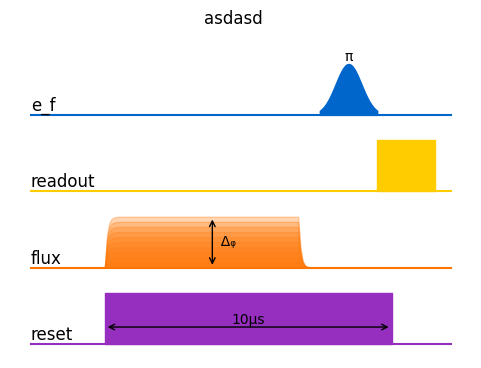

In [8]:
reset_line = Line("reset").attach_elements(Element(0, 5).set(xlabel="10μs"))
flux_line = Line("flux").attach_elements(
    flux_rise := Element.ExpFilter(0, 3.75, duration=0.2)
    .set(ylabel="  Δᵩ")
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1)
)

ef_line = Line("e_f").attach_elements(
    ef_pi := Element.Gaussian(flux_rise, duration=1).set(subtitle="π")
)
readout_line = Line("readout").attach_elements(Element(ef_pi, duration=1, delay=0.5))
ens = ef_line + readout_line + flux_line + reset_line

figsize = (1 * 6, 4)  # (2 * 8, len(ens.lines) * 0.8)
fig, ax1 = plt.subplots(1, 1, figsize=figsize)

ens.draw(ax1).config_ax(ax1)
fig.suptitle("asdasd")

# xlim = ax1.get_xlim()
# ylim = ax1.get_ylim()
# xs = xlim[1] - xlim[0]
# ys = ylim[1] - ylim[0]


# ax1.set_aspect(0.5 / (ys / xs))
# ys / xs

set aspect to 0.3333333333333333


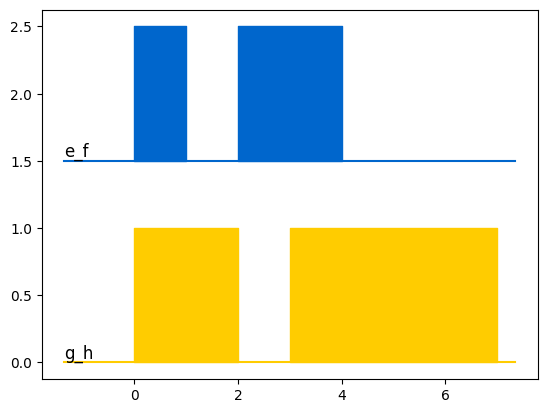

In [11]:
# Define a line with elements attached
line1 = Line("e_f").attach_elements(Element(0, 1), Element(2, 4))

# Define another line
line2 = Line("g_h").attach_elements(Element(0, 2), Element(duration=4, delay=1))

# Create a figure and axis
fig, ax = plt.subplots(1, 1)
# Combine the lines into an ensemble and draw
ens = line1 + line2
ens.draw(ax).config_ax(ax1)

plt.show()

matplotlib.rcParams["legend.fontsize"]

set aspect to 0.3333333333333333


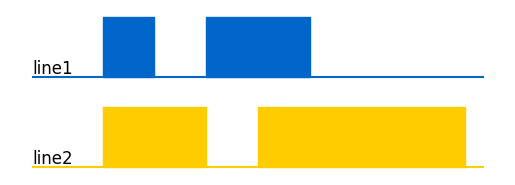

In [14]:
line1 = Line("line1").attach_elements(Element(0, 1), Element(2, 4))

# Define another line
line2 = Line("line2").attach_elements(Element(0, 2), Element(duration=4, delay=1))

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Combine the lines into an ensemble and draw
(line1 + line2).draw(ax).config_ax(ax)


plt.show()

set aspect to 0.6666666666666666


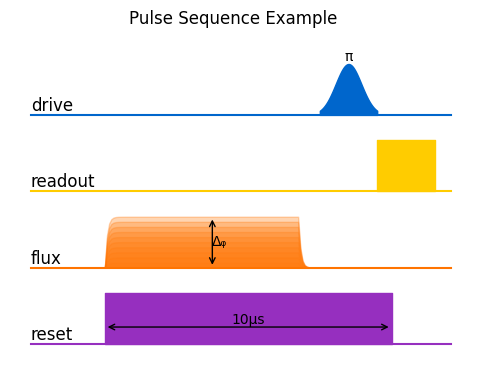

In [15]:
reset_line = Line("reset").attach_elements(Element(0, 5).set(xlabel="10μs"))
flux_line = Line("flux").attach_elements(
    flux_rise := Element.ExpFilter(0, 3.75, duration=0.2)
    .set(ylabel="Δᵩ")
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1)
)

drive_line = Line("drive").attach_elements(
    drive_pi := Element.Gaussian(flux_rise, duration=1).set(subtitle="π")
)
readout_line = Line("readout").attach_elements(Element(drive_pi, duration=1, delay=0.5))

# Combine all lines into an ensemble
ens = drive_line + readout_line + flux_line + reset_line

# Plotting the ensemble
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ens.draw(ax1).config_ax(ax1)
fig.suptitle("Pulse Sequence Example")
plt.show()

set aspect to 0.3333333333333333


LineEnsemble with 2 lines :
	Line : drive
	Line : flux

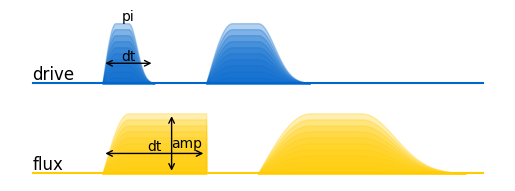

In [23]:
from pulsefig import Element, Line, LineEnsemble
import numpy as np
import matplotlib.pyplot as plt

# Define a line with elements attached
line1 = Line("drive").attach_elements(
    Element(0, 1)
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1)
    .set(subtitle="pi", xlabel="dt"),
    Element(2, 4)
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
)

# Define another line
line2 = Line("flux").attach_elements(
    Element(0, 2)
    .set(alpha=0.3, marker="0", xlabel="dt", ylabel="amp")
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
    Element(duration=4, delay=1)
    .attach_func(lambda x: np.sin(x * 2 * np.pi), end=0.25)
    .attach_func(lambda x: np.exp(-((x - 0.5) ** 2) / 0.05), start=0.5, end=1)
    .update_style(alpha=0.3, data_index=0)
    .sweep_height(start_alpha=0.1),
)

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Combine the lines into an ensemble and draw
(line1 + line2).draw(ax).config_ax(ax)

In [17]:
1

1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
t 2 4
FloatProxy Link to Element :  (0, 2)._y_offset = 3.6
FloatProxy Link to Element :  (0, 2)._y_offset = 3.6
7.2


LineEnsemble with 3 lines :
	Line : Reset
	Line : Readout
	Line : Simple line

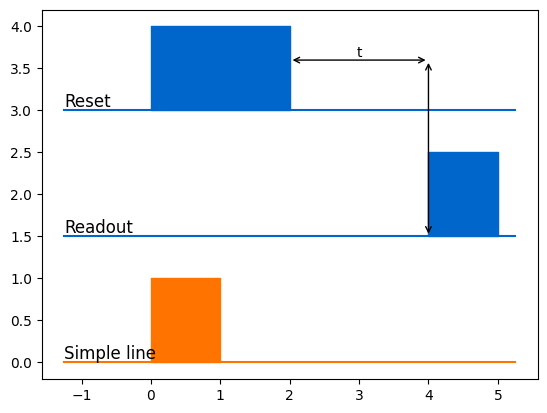

In [22]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pulsefig
from pulsefig.element import Element
from pulsefig.line import Line, LineEnsemble
import numpy as np
import uastyle



simple_line = Line("Simple line").attach_elements(Element(0, 1))
readout_line = Line("Readout", style={"color": uastyle.colors[0]}).attach_elements(
    readout_elm := Element(4, duration=1),
)
reset_line = Line("Reset", style={"color": uastyle.colors[0]}).attach_elements(
    reset_elm := Element(0, duration=2),
)

# reset_elm.annotation_to(readout_elm, "t")


fig, ax = plt.subplots(1, 1)
# Combine the lines into an ensemble and draw
reset_elm.annotation_to(readout_elm, "t")
(reset_line + readout_line + simple_line).draw(ax)#.config_ax(ax)

In [20]:
readout_elm.end

5

FloatProxy Link to Element :  (0, 2)._y_offset = 1.5